<a href="https://colab.research.google.com/github/bsussel3/2023-s1-ci/blob/main/aula_03_kNN_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kNN e busca de hiperparâmetros

Nesta atividade, vamos utilizar o modelo kNN (*k-nearest neighbors*) para abordar o problema de detecção de diabetes a partir de um conjunto de atributos pessoais (como idade) e de medidas relacionadas ao organismo de cada pessoa (como a pressão sanguínea).

*Dataset*: https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data


## Roteiro

**Passos principais:**

- *Dataset*: carregar os dados e analisar as suas características.
  - É necessário realizar algum pré-processamento?

- Metodologia:
  - 1ª tentativa: *holdout* - um único particionamento em treinamento, validação e teste
  - 2ª tentativa: *k-fold*

- Busca de hiperparâmetros:
  - Busca em grade + validação cruzada: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

- Aplicação ao conjunto de teste: uma vez escolhida a melhor configuração para o modelo, um último treinamento é realizado em todos os dados (exceto os de teste) e, finalmente, o modelo faz as previsões para as amostras de teste.



### Passo 1: carregar os pacotes

In [1]:
""" Importando os pacotes necessários """

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Acrescentar pacotes necessários do Scikit-Learn

### Passo 2: baixando o *dataset* do Github

In [2]:
""" Carregando o dataset do Github para trabalhar autonomamente no Colab """

import requests
from pathlib import Path

# Caminho para a pasta que conterá o dataset
data_path = Path("data/")

# Se o diretório ainda não existe, criamos e baixamos o dataset
if data_path.is_dir():
    print(f"O diretório {data_path} já existe")
else:
    print(f"Diretório {data_path} não localizado, criando um ...")
    data_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "diabetes.csv", "wb") as f:
        request = requests.get("https://github.com/EA991-Lab/utils/raw/main/data/diabetes.csv")
        print("Baixando os dados ...")
        f.write(request.content)

Diretório data não localizado, criando um ...
Baixando os dados ...


### Passo 3: análise inicial do *dataset*

In [53]:
""" Carregamos o dataset e analisamos algumas de suas características """

#leitura do arquivo completo de dados
data = pd.read_csv(data_path / "diabetes.csv")

#dicionário para mapear as classes nos números desejados
labels = {0: 'Normal', 1: 'Diabetes'}

#acrescenta a coluna 'labels' mapeando os valores de 'Outcome' conforme o dicionário criado
data['labels'] = data['Outcome'].map(labels)

#nomes das classes
class_names = ['Normal','Diabetes']

#visualização de parte inicial do dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,labels
0,6,148,72,35,0,33.6,0.627,50,1,Diabetes
1,1,85,66,29,0,26.6,0.351,31,0,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Diabetes
3,1,89,66,23,94,28.1,0.167,21,0,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Diabetes


### Passo 4: estendendo a análise

* Balanceamento das classes
* Estatísticas básicas dos atributos (média, máx., mín., etc.)
* Histogramas por atributo
  

In [54]:
""" Análise do balanceamento das classes """
n_rows = data.shape[0]
a = data['Outcome'].to_numpy()
n_diabetes = np.count_nonzero(a)
print(f"Número de casos com diabetes: {n_diabetes} ({n_diabetes * 100 / n_rows}%)")
print(f"Número de casos sem diabetes: {n_rows - n_diabetes} ({(n_rows - n_diabetes) * 100 / n_rows}%)")

Número de casos com diabetes: 268 (34.895833333333336%)
Número de casos sem diabetes: 500 (65.10416666666667%)


In [55]:
""" Análise das estatísticas básicas dos atributos """
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [63]:
# Retirar dados nulos que não fazem sentido
data.loc[:,"Glucose":"BMI"] = data.loc[:,"Glucose":"BMI"].replace(0, np.nan).to_numpy()

<ipython-input-63-9809d0e49040>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[148.  85. 183.  89. 137. 116.  78. 115. 197. 125. 110. 168. 139. 189.
 166. 100. 118. 107. 103. 115. 126.  99. 196. 119. 143. 125. 147.  97.
 145. 117. 109. 158.  88.  92. 122. 103. 138. 102.  90. 111. 180. 133.
 106. 171. 159. 180. 146.  71. 103. 105. 103. 101.  88. 176. 150.  73.
 187. 100. 146. 105.  84. 133.  44. 141. 114.  99. 109. 109.  95. 146.
 100. 139. 126. 129.  79.  nan  62.  95. 131. 112. 113.  74.  83. 101.
 137. 110. 106. 100. 136. 107.  80. 123.  81. 134. 142. 144.  92.  71.
  93. 122. 163. 151. 125.  81.  85. 126.  96. 144.  83.  95. 171. 155.
  89.  76. 160. 146. 124.  78.  97.  99. 162. 111. 107. 132. 113.  88.
 120. 118. 117. 105. 173. 122. 170.  84.  96. 125. 100.  93. 129. 105.
 128. 106. 108. 108. 154. 102.  57. 106. 147.  90. 136. 114. 156. 153.
 188. 152.  99. 109.  88. 163. 151. 102. 114. 100. 131. 104. 148. 

In [64]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,labels
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,Diabetes
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,Normal
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,Diabetes
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Diabetes


In [66]:
# Estatísticas básicas após retirar dados nulos
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Histogramas por atributo

Completar com o trecho do `DataFrame` que contém os atributos a analisar

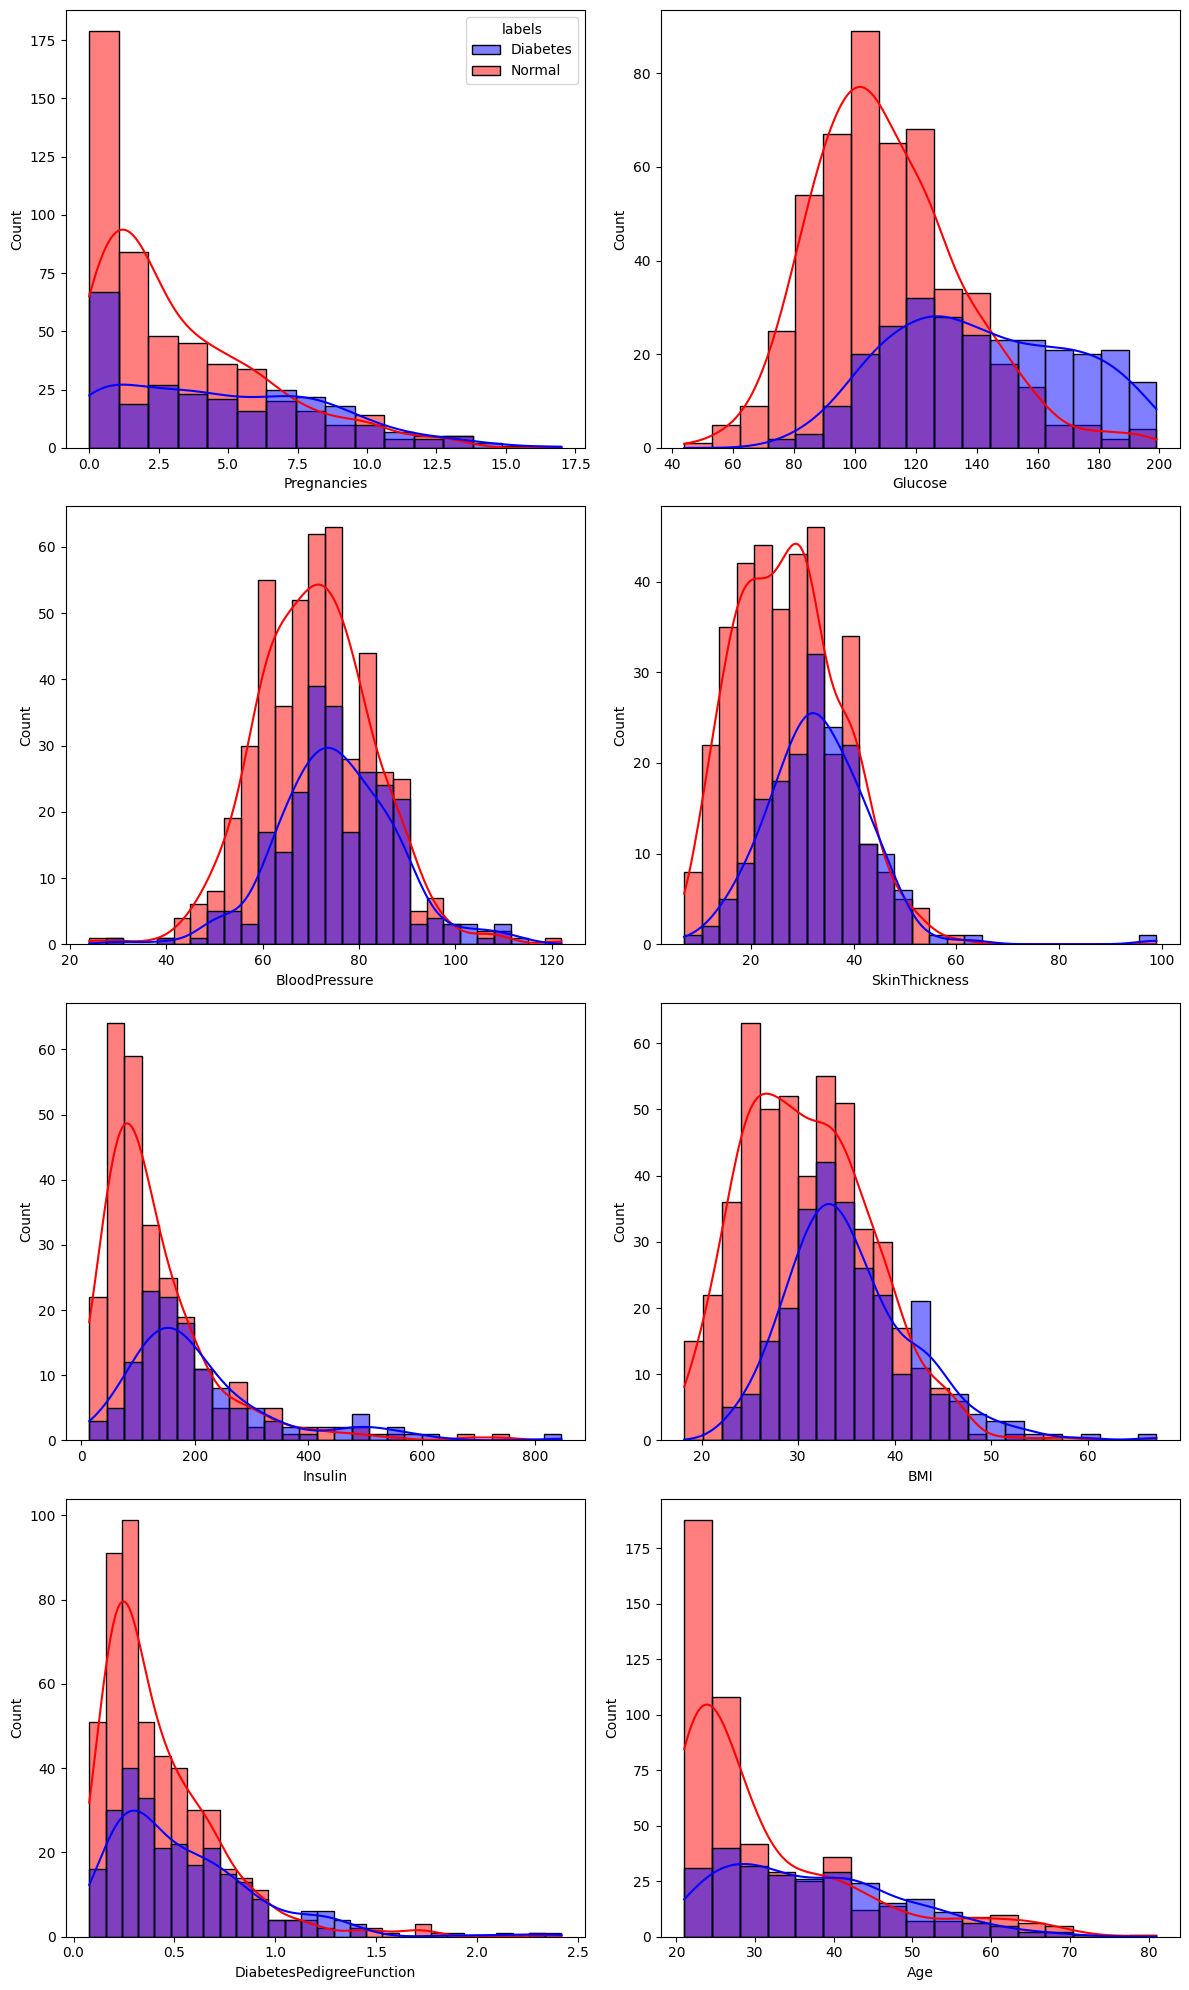

In [72]:
""" Histogramas por atributo """
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
for col, ax in zip(data.drop(["Outcome", "labels"], axis=1).columns, axs.flat):
    sns.histplot(data=data, x=col, kde=True, hue='labels', common_norm=False, palette = ['blue','red'],legend=ax==axs[0,0], ax=ax)
plt.tight_layout()
plt.show()

### Passo 5: preparar o conjunto de dados

- Opção 1: separar um único conjunto de validação e fazer a avaliação de desempenho em função do número de vizinhos mais próximos;
- Opção 2: utilizar *k-fold* no momento da busca de hiperparâmetros.

**Observação:** devido ao desbalanceamento, pensem na possibilidade de fazer a divisão com estratificação (`stratify = y`, onde `y` denota o conjunto de rótulos para a partição).

In [ ]:
""" Particionamento do dataset """

...
...



### Passo 6: busca de hiperparâmetros

**Objetivo:** exibir a curva de progressão de uma métrica de desempenho no conjunto de validação em função do valor de $k$.

Recomendação: quando houver múltiplos *folds* de validação, mostre a curva com a média do desempenho de validação e barras de dispersão baseadas no desvio padrão (ou, se preferir, nos valores máximos e mínimos).

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html

In [ ]:
""" Busca de hiperparâmetros """

...
...

### Passo 7: seleção do melhor *k*, treinamento completo e aplicação ao conjunto de teste

Mostre:
- Matriz de confusão
- Relatório de classificação
- F1-score
- Curva ROC

https://scikit-learn.org/stable/api/sklearn.metrics.html

In [ ]:
""" Treinamento completo e avaliação no conjunto de teste """

...
...
